# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ema_workbench import (
    ema_logging,
    Scenario,
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
    Policy,
    MultiprocessingEvaluator,
    load_results, save_results,
    ScalarOutcome
)


from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
from ema_workbench.analysis import parcoords, prim
from problem_formulation import get_model_for_problem_formulation
from MORDM_pyfile import MORDM_function


## Define calculation metrics
Calculation metrics are used to determine convergence, which says something about the success of the optimization. 

In [9]:
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers", reference=reference_scenario)

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)
    
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

# Define model and reference scenario

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

## Optimization
Defining the convergence metrics to see whether the optimization went correctly. The archive gets saved to track changes in convergence. Afterwards, optimization is run using 10.000 nfe and 0.5 epsilons. This resulted in a large amount of solutions.

The optimization is done using a .py file to prevent errors.

In [9]:
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimization_10000x05.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

In [10]:
nfe = 10000
epsilons = 0.5

results, convergence = MORDM_function(dike_model, reference_scenario, nfe, epsilons, convergence_metrics)

[MainProcess/INFO] pool started with 16 workers
10819it [10:36, 17.01it/s]                                                     
[MainProcess/INFO] optimization completed, found 230 solutions
[MainProcess/INFO] terminating pool


# Calculate metrics to check convergence

By calculating the convergence, we can see whether the optimization was good enough to use. If for example the hypervolume is still increasing when we stop the optimization, it means the optimization is not yet ready and there are more optimal solutions to be found still.

In [133]:
archives = ArchiveLogger.load_archives(f"./optimization_10000x05.tar.gz")
for key in archives:
    if 'Unnamed: 0' in archives[key].columns:
        archives[key] = archives[key].drop(columns=['Unnamed: 0'])
reference_set = archives[max(archives.keys())] # this is the final archive

In [134]:
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

1
2
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended
scores appended


NameError: name 'convergence' is not defined

# Visualise outcomes of optimization

The graph below shows all the solutions that were found and the corresponding outcome values. Keep in mind that the optimizer was told to try and minimise all outcome values.

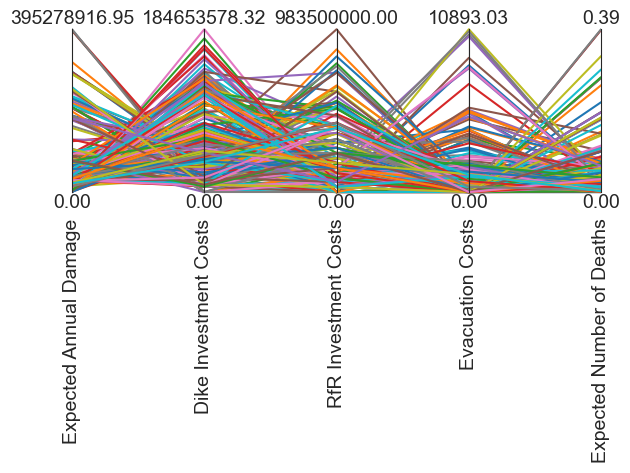

In [211]:
outcomes = reference_set.loc[:, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('Expected Number of Deaths') 
# plt.show()


Since the graph above is rather difficult to read, we will consider the maximum and minium of all values as candidate policies. We can then use these to test for robustness and pick the most robust solution.

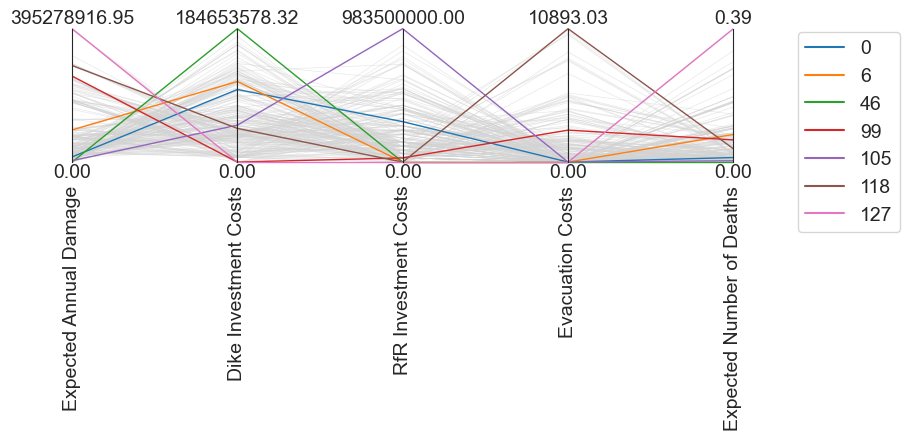

In [212]:
# conditional on y
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across 
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
paraxes = parcoords.ParallelAxes(limits)

paraxes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)

# Plot the unique lines with different colors
for i, (index, row) in enumerate(all_data.iloc[indices].sort_index().iterrows()):
    paraxes.plot(row, color=colors[i], lw=1, label=str(index))

# Create a legend
paraxes.legend()

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

As you can see in the graph above, there are a few solutions that get your attention. Namely the ones with low Expected Annual Damage and Expected Number of Deaths; policies 0, 46 and 105, and maybe 6 if our policy actor is working with a budget. 

# Robustness test

In this section, we will test all 7 candidate policies for robustness. This is done by taking the candidate policies and running them through a lot of different scenario's. This way we can see how they react to different scenario's, as the optimization was done using the reference scenario. This means that the candidate solutions are only optimal given the reference scenario.

However, we will remove policy 127 from the robustness tests. Since they did not use any levers to reduce expected damages and deaths, this is not a policy that is of any use to the policy actors who want to minimise these outcomes. 

In [213]:
# Remove policy 105
indices_list = list(indices)
indices_list.remove(127)
indices = np.array(indices_list)

In [214]:
candidate_solutions = reference_set.iloc[indices]
candidate_solutions = candidate_solutions.drop([o.name for o in dike_model.outcomes], axis=1)

candidate_policies = []

for i, policy in candidate_solutions.iterrows():
    candidate_policies.append(Policy(str(i), **policy.to_dict()))

In [1]:
indices

NameError: name 'indices' is not defined

In [215]:
candidate_solutions

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
46,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,3,7,0,4,0,0
105,0,0,1,0,0,1,1,1,0,1,...,0,0,0,0,1,1,0,0,0,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
99,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,4,3,3,0,0
0,1,0,0,0,0,0,1,1,1,1,...,0,1,0,1,1,6,4,2,0,0


In [216]:
n_scenarios = 20000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            candidate_policies)
    
save_results(results, 'robustness_20000.tar.gz')

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 20000 scenarios * 6 policies * 1 model(s) = 120000 experiments
100%|████████████████████████████████| 120000/120000 [1:52:08<00:00, 17.83it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\31650\OneDrive - Delft University of Technology\Documents\Python\modelbased\final assignment\robustness_20000.tar.gz


In [7]:
results = load_results('3.1 results_LHS_3000x50.tar.gz')

## Signal-Noise ratio

In [14]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [5]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

NameError: name 'results' is not defined

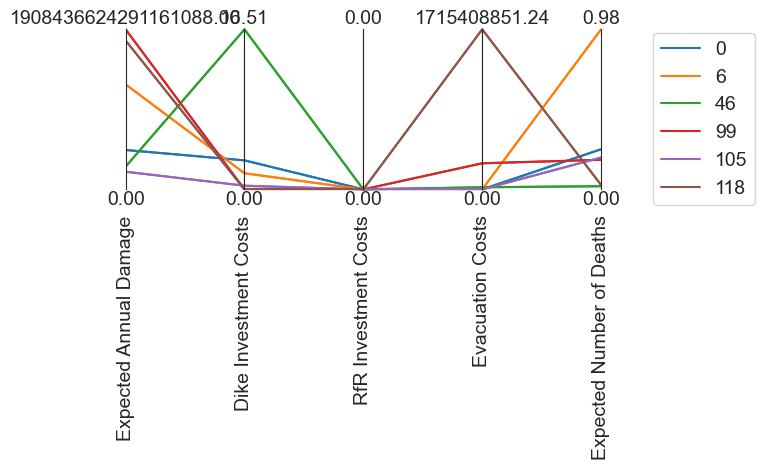

In [220]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']] = 0
paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
paraxes.plot(data)
plt.show()

It appears that policies 105 and 0 score best in signal-to-noise ratio. This might imply that these policies are the most robust.

## Maximum regret

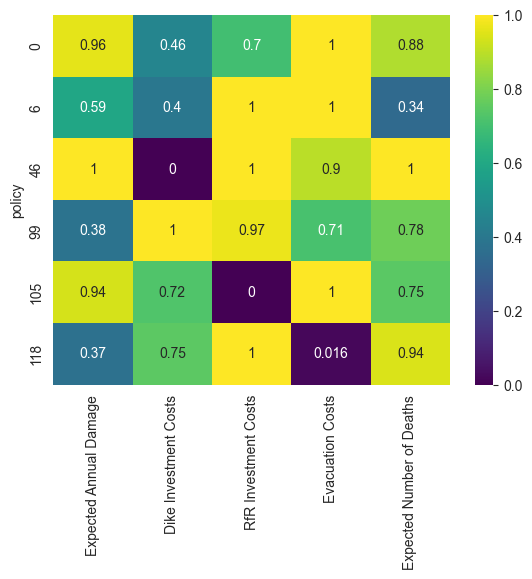

In [221]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

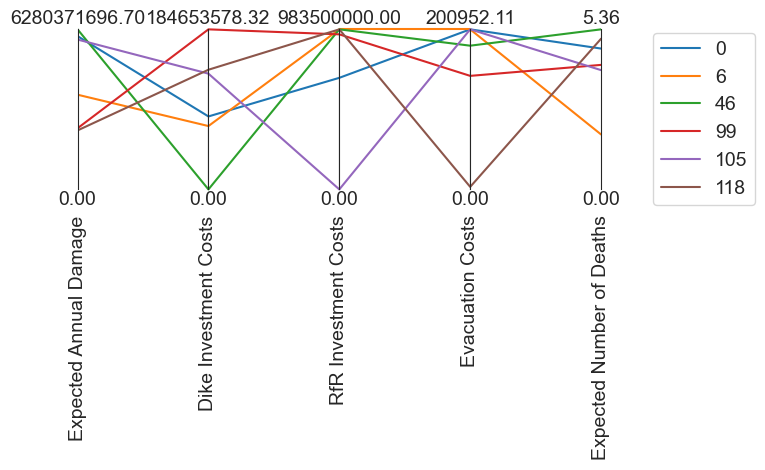

In [222]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

The maximum regret paints a different picture than the signal-to-noise ratio, although there does not appear to be one single policy to be the most robust when looking at maximum regret. When looking at the total costs of the different policies we see that policy 0 is about half as cheap as policy 105, as 105 invests a lot in RfR. Given this difference of about 500 million, we will select policy 0 as the best solution.

## Scenario Discovery

In [168]:
df_outcomes = pd.DataFrame.from_dict(outcomes)

In [174]:
df_sd = experiments.join(df_outcomes, how='outer')

In [181]:
df_policy0 = df_sd.loc[df_sd.policy == 0]

In [190]:
df_damages = pd.DataFrame(df_policy0['Expected Annual Damage'])
df_deaths = pd.DataFrame(df_policy0['Expected Number of Deaths'])

In [191]:
df_deaths

,Expected Number of Deaths
100000,0.006693
100001,0.051955
100002,0.506496
100003,0.024638
100004,0.178500
...,...
119995,0.030144
119996,0.133757
119997,0.202719
119998,0.508806


In [192]:
df_damages['y_worst'] = df_damages['Expected Annual Damage'] < np.percentile(df_damages['Expected Annual Damage'], 10)
df_deaths['y_worst'] =df_deaths['Expected Number of Deaths'] < np.percentile(df_deaths['Expected Number of Deaths'], 10)

In [197]:
experiments_uncertainties = df_policy0.iloc[:, :19]

In [201]:
experiments_uncertainties

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
100000,60,230.494526,1.5,0.913711,217.237142,1.0,0.735373,326.102360,1.0,0.810405,33.834977,1.5,0.844545,142.862735,1.5,0.558011,1.5,3.5,2.5
100001,25,111.211552,1.0,0.255644,175.508864,1.5,0.632939,210.829111,1.0,0.454640,346.090338,1.0,0.859603,306.943831,1.0,0.713165,4.5,2.5,2.5
100002,101,85.361599,1.5,0.616200,256.610044,10.0,0.043374,245.269535,10.0,0.300072,331.318870,1.0,0.322317,191.372967,10.0,0.774553,1.5,3.5,2.5
100003,45,302.291612,1.5,0.807047,87.729845,1.5,0.600518,218.232587,10.0,0.592094,169.334614,1.0,0.426219,110.131522,10.0,0.401267,2.5,3.5,1.5
100004,89,106.285984,1.5,0.607017,207.360691,10.0,0.131766,329.394650,1.5,0.400786,227.788939,10.0,0.095679,123.192063,1.0,0.500013,4.5,4.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,81,122.194883,1.0,0.559562,38.525237,10.0,0.933047,210.698927,10.0,0.746035,93.093793,1.5,0.412338,171.330938,1.0,0.413722,3.5,3.5,3.5
119996,120,208.498298,1.0,0.994200,134.951102,1.0,0.137195,124.796253,1.0,0.726078,166.188898,1.0,0.628419,60.045852,10.0,0.457946,3.5,4.5,3.5
119997,33,92.842956,1.5,0.850724,36.996023,10.0,0.563375,123.856233,1.5,0.169672,166.287857,1.0,0.469342,214.955552,10.0,0.181274,4.5,4.5,1.5
119998,82,60.000986,1.5,0.403018,344.359275,1.0,0.038820,309.699639,1.0,0.907246,37.598847,1.0,0.401313,260.888896,1.5,0.199411,1.5,1.5,4.5


In [202]:
df_damages['y_worst'].values

array([ True, False, False, ..., False, False, False])

In [204]:
prim_alg = prim.Prim(experiments_uncertainties,df_damages['y_worst'].values, threshold=0.8)
box_damages = prim_alg.find_box()

[MainProcess/INFO] 20000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 0.9653808110781404, mass: 0.05055, coverage: 0.488, density: 0.9653808110781404 restricted_dimensions: 5


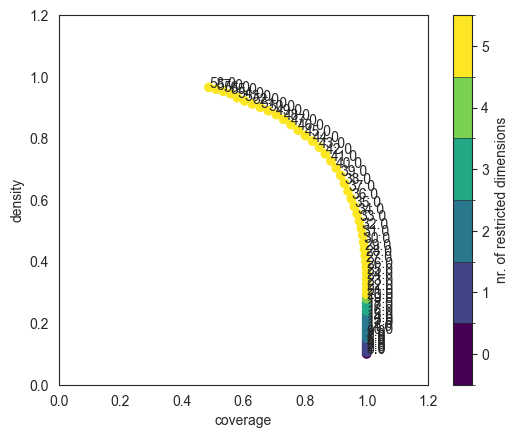

In [205]:
box_damages.show_tradeoff(annotated=True)
plt.show()

It appears that PRIM can find a good box. This means that the cases of interest (worst values of the expected damages) are relatively compact in the uncertainty space. Box 45 has a coverage of 80%, which means that of all 2000 cases of interest, 80% reside in box 45. It also has a density of 81%, which means that of all the cases in the box, 81% are of interest. This means that the box is probably rather small, which is good!

[<Figure size 640x480 with 1 Axes>]

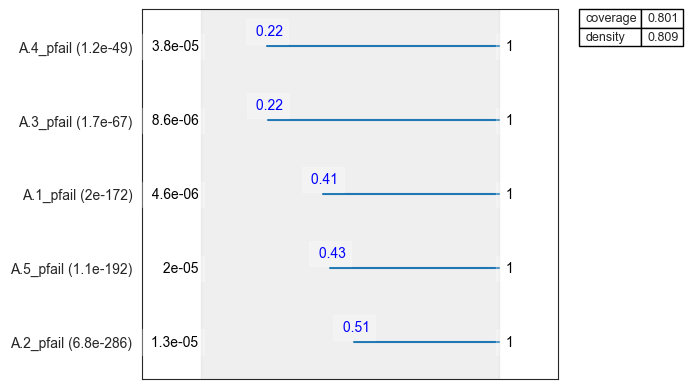

In [206]:
box_damages.inspect(45, style='graph')

In [207]:
prim_alg = prim.Prim(experiments_uncertainties,df_deaths['y_worst'].values, threshold=0.8)
box_deaths = prim_alg.find_box()

[MainProcess/INFO] 20000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 0.9475766567754699, mass: 0.05055, coverage: 0.479, density: 0.9475766567754699 restricted_dimensions: 5


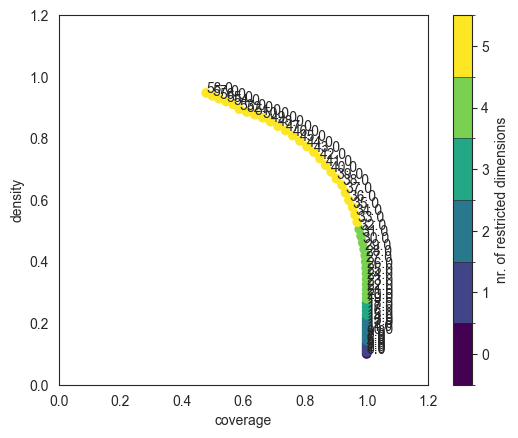

In [208]:
box_deaths.show_tradeoff(annotated=True)
plt.show()

The same goes for scenario discovery of the worst cases of deaths. It appears PRIM can find a good box with a high density and coverage.

[<Figure size 640x480 with 1 Axes>]

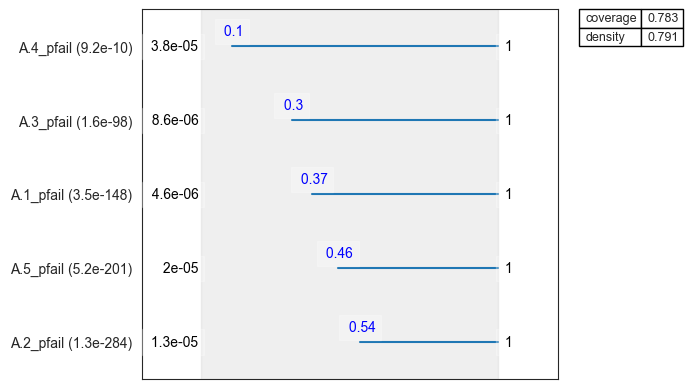

In [209]:
box_deaths.inspect(45, style='graph')